### Normal likelihood

$L(\mu,\sigma^2|x_1,...,x_n)= (2\pi\sigma^2)^{(-n/2)}\exp\left(-\dfrac{1}{2\sigma^2}\sum_{j=1}^{n} (x_j-\mu)^2\right)$

ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 


In [41]:
import math, numpy as np, matplotlib.pyplot as plt

def calc_normal_likelihood(mu,sigma,X):
    n = len(X)
    c1 = (2*np.pi*sigma**2)**(-n/2)
    c2 = -1/(2*sigma**2)
    exp_sum = np.sum(np.square(X-mu))
    L = c1*np.exp(c2*exp_sum)
    return L

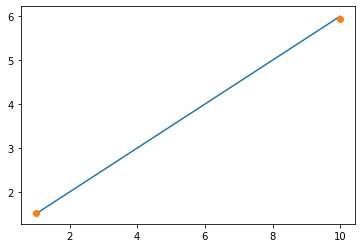

In [63]:
sigma = 0.1
n_data = 2

a = 0.5
b = 1
t = np.linspace(1,10, n_data)
y_true = a*t+b
y_obs = y_true + np.random.normal(0, sigma, len(y_true))

plt.plot(t,y_true)
plt.plot(t,y_obs, 'o')

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_6899/1279493085.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(a_tmp, b_tmp, Z)


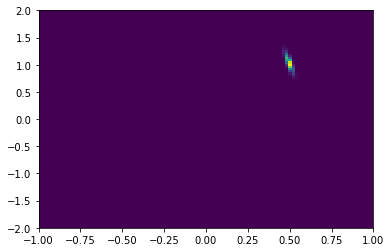

In [64]:
a_vals = np.linspace(-1,1,100)
b_vals = np.linspace(-2,2,100)

def f(a, b, sigma, mu, t): 
    X = a*t+b
    L = calc_normal_likelihood(mu,sigma,X)
    return L

a_tmp, b_tmp = np.meshgrid(a_vals,b_vals)
Z = np.zeros((100,100))

for i in range(100):
    for j in range(100):
        Z[i,j] = f(a_tmp[i,j],b_tmp[i,j],sigma,y_obs,t)

plt.pcolor(a_tmp, b_tmp, Z)
plt.show()